In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

#**Loading mnist and synthetic datasets**

##Loading mnist datasets

In [ ]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/datasets/"

In [ ]:
#Loading mnist_5. Each class has 5 elements
bldr = tfds.ImageFolder(path +'mnist_5/')
datasets_5 = bldr.as_dataset(split='train', shuffle_files=False)

#Loading mnist_10. Each class has 10 elements
bldr = tfds.ImageFolder(path +'mnist_10/')
datasets_10 = bldr.as_dataset(split='train', shuffle_files=False)

#Loading mnist_20. Each class has 20 elements
bldr = tfds.ImageFolder(path +'mnist_20/')
datasets_20 = bldr.as_dataset(split='train', shuffle_files=False)

#Loading mnist_40. Each class has 40 elements
bldr = tfds.ImageFolder(path +'mnist_40/')
datasets_40 = bldr.as_dataset(split='train', shuffle_files=False)

#Loading mnist_80. Each class has 80 elements
bldr = tfds.ImageFolder(path +'mnist_80/')
datasets_80 = bldr.as_dataset(split='train', shuffle_files=False)

#Loading mnist_160. Each class has 160 elements
bldr = tfds.ImageFolder(path +'mnist_160/')
datasets_160 = bldr.as_dataset(split='train', shuffle_files=False)

##Loading synthetic datasets

In [ ]:
#Loading mnistGAN_reduced_to_5. Each class has 400 GAN generated elements created with only 5 real images
bldr = tfds.ImageFolder(path +'mnistGAN_reduced_to_5/')
mnistGAN_5 = bldr.as_dataset(split='train', shuffle_files=False)

#Loading mnistGAN_reduced_to_10. Each class has 400 GAN generated elements created with only 10 real images
bldr = tfds.ImageFolder(path +'mnistGAN_reduced_to_10/')
mnistGAN_10 = bldr.as_dataset(split='train', shuffle_files=False)

#Loading mnistGAN_reduced_to_10. Each class has 400 GAN generated elements created with only 20 real images
bldr = tfds.ImageFolder(path +'mnistGAN_reduced_to_20/')
mnistGAN_20 = bldr.as_dataset(split='train', shuffle_files=False)

#**Functions**

##Edititng datases

In [ ]:
#ds: dataset; filter_list: list with elements to filter for; b: boolean for setting map function
def filterAndCastDs(ds, filter_list = [], b = False):

  if b:
    mapping = lambda item: (tf.cast(item['image'], tf.float32)/255.0, tf.cast(item['label'], tf.int32))

    if len(filter_list)==2:
      filtering = lambda f: (f['label']==filter_list[0])|(f['label']==filter_list[1])
      ds1 = ds['train'].filter(filtering).map(mapping)
      ds2 = ds['test'].filter(filtering).map(mapping)

    elif len(filter_list)==3:
      filtering = lambda f: (f['label']==filter_list[0])|(f['label']==filter_list[1])|(f['label']==filter_list[2])
      ds1 = ds['train'].filter(filtering).map(mapping)
      ds2 = ds['test'].filter(filtering).map(mapping)
      
    else:
      ds1 = ds['train'].map(mapping)
      ds2 = ds['test'].map(mapping)

    return ds1, ds2

  else:
    mapping = lambda item: CastT(item)

    if len(filter_list)==2:
      filtering = lambda f: (f['label']==filter_list[0])|(f['label']==filter_list[1])
      ds1 = ds.filter(filtering).map(mapping)

    elif len(filter_list)==3:
      filtering = lambda f: (f['label']==filter_list[0])|(f['label']==filter_list[1])|(f['label']==filter_list[2])
      ds1 = ds.filter(filtering).map(mapping)
      
    else:
      ds1 = ds.map(mapping)

    return ds1

#ds: dataset
def CastT(ds):
  image = ds['image']
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = ds['label']
  label = tf.cast(label, tf.int32)

  return (image, label)

In [ ]:
#filter_list: list containing values to filter for; m: multiplicator
def prepareDs(filter_list):
 
  if len(filter_list)==0:
    m = 10
  else:
    m = len(filter_list)

  list_a = []
  list_a.append(filterAndCastDs(datasets_5, filter_list))
  list_a.append(filterAndCastDs(datasets_10, filter_list))
  list_a.append(filterAndCastDs(datasets_20, filter_list))
  list_a.append(filterAndCastDs(datasets_40, filter_list))
  list_a.append(filterAndCastDs(datasets_80, filter_list))
  list_a.append(filterAndCastDs(datasets_160, filter_list))

  list_b = []
  list_b.append(takeAndConcat(list_a[0],filterAndCastDs(mnistGAN_5, filter_list), 6, m*5))
  list_b.append(takeAndConcat(list_a[1],filterAndCastDs(mnistGAN_10, filter_list), 6, m*10))
  list_b.append(takeAndConcat(list_a[2],filterAndCastDs(mnistGAN_20, filter_list), 6, m*20))

  return list_a, list_b

def takeAndConcat(ds1, ds2, rg = 5, steps = 10, start = 0):
  tf.random.set_seed(1)
  ds_list = []
  ds2 = ds2.shuffle(buffer_size=5000, reshuffle_each_iteration=False)

  for i in range(rg):
    temp = ds2.take(((i+1)*steps)+start)
    ds_list.append(ds1.concatenate(temp))
  
  return ds_list

In [ ]:
#ds_list: list of datasets; bs: buffer size; s: seed
def shuffleList(ds_list, bs, s):
  for i in range(len(ds_list)):
    tf.random.set_seed(s)
    ds_list[i] = ds_list[i].shuffle(buffer_size=bs, reshuffle_each_iteration=False)

  return ds_list

##Create and train CNNs

In [ ]:
def classifierCNN():
 model = tf.keras.Sequential()
 model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding='same',
                                  data_format='channels_last', name='conv_1', activation='relu'))
 model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))
 model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1),padding='same',
                                  name='conv_2', activation='relu'))
 model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))
 model.add(tf.keras.layers.Flatten())
 model.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
 model.add(tf.keras.layers.Dropout(rate=0.5))
 model.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

 return model
  
#ds_list_train: list with training sets; ds_test: validation set; epoch_list: training epochs; seed_list: list with seeds
def trainCNNlist(ds_list_train, ds_test, epoch_list, seed_list):
  tr_global = []

  for SEED in seed_list:
    
    ds_list_t = shuffleList(ds_list_train, BUFFER_SIZE, SEED)
    
    ds_cnn_list = []
    for i in range(len(ds_list_t)):
      ds_train = ds_list_t[len(ds_list_t)-i-1].batch(4)
      
      if type(epoch_list)==list:
        epoch = epoch_list[len(epoch_list)-i-1]
      else:
        epoch = epoch_list

      tf.random.set_seed(SEED)
      ds_cnn_list.append(trainCNN(ds_train, epoch))
    
    tr = testCNN(ds_test, ds_cnn_list)
    tr_global.append(tr)
  
  tr_global = resultsMean(tr_global, len(seed_list))

  return tr_global

#ts: training set; vs: validation set; epoch: training epochs
def trainCNN(ts, epoch = 1):
  cnn = classifierCNN()
  cnn.build(input_shape=(None, 28, 28, 1))
  cnn.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  history = cnn.fit(ts, epochs = epoch, shuffle = True, verbose = 0)

  return cnn

#function evaluating CNNs with validation set
def testCNN(ds_list, trained_cnn):
  results=[]
  for i in range(len(trained_cnn)):
    results.append(trained_cnn[i].evaluate(ds_list.batch(8), verbose=0))

  return results
  
#function to calculate mean of all completed training runs for each CNN
def resultsMean(tr_list, n):
  a = np.array(tr_list)
  res = np.sum(a/n, axis=0)

  return res

##Visualizations

In [ ]:
def labelListMaker(rg, steps, start = 0):
  label_list = []
  for i in range(rg):
    label_list.append(str(((i+1)*steps)+start))

  return label_list

def visualizeComparison(filter_list, tr):
  acc_values = []
  for i in range(len(tr)):
    acc_values.append(tr[i][1])

  if len(filter_list)==2:
    plt.title("Classifier Accuracy for distinguishing classes " + str(filter_list[0]) + " and " + str(filter_list[1]))

  elif len(filter_list)==3:
    plt.title("Classifier Accuracy for distinguishing classes " + str(filter_list[0]) + ", " + str(filter_list[0])+" and "+ str(filter_list[2]))

  else:
    plt.title("Classifier Accuracy for distinguishing all classes ")
   
  plt.xlabel("Real data available per class")
  plt.ylabel("Accuracy")
  plt.ylim([0, 1.05])
  plt.yticks(np.arange(0, 1.1, step=0.1))
  plt.grid(axis="y", linestyle="--")
  plt.bar(elem_per_class, acc_values, width=0.25, color="b")
  plt.plot(elem_per_class, acc_values,":", color="b")
  plt.show()

def visualize(filter_list, tr, tr_gan, bar = True):
  
  if len(filter_list)==0:
    m = 10
  else:
    m = len(filter_list)

  label_list = []
  label_list.append(labelListMaker(6, m*5))
  label_list.append(labelListMaker(6, m*10))
  label_list.append(labelListMaker(6, m*20))

  acc_values = []
  for i in range(len(tr)):
    acc_values.append(tr[i][1])

  fig, ax = plt.subplots(len(tr_gan),1,figsize=(20,24))

  if bar:
    for i in range(len(tr_gan)):
      acc_values_gan = []

      for j in range(len(tr_gan[i])):
        acc_values_gan.append(tr_gan[i][len(tr_gan[i])-1-j][1])

      hline = acc_values[len(acc_values)-1-i]

      ax[i].set_title("Real data available per class: "+elem_per_class[len(elem_per_class)-1-i])
      ax[i].set(xlabel="Added synthtic data from GAN", ylabel="Accuracy")
      ax[i].set_ylim([0, 1.05])
      ax[i].set_yticks(np.arange(0, 1.1, step=0.1))
      ax[i].grid(axis="y", linestyle="--")
      ax[i].bar(label_list[i], acc_values_gan, width=0.25, color="g", label="GAN generated")
      ax[i].plot(label_list[i], acc_values_gan,":", color="g")
      ax[i].axhline(y=hline, color="b", linestyle="-", label="Real data")
      ax[i].legend(loc=4)

  else:
    for i in range(len(tr_gan)):
      acc_values_gan = []

      for j in range(len(tr_gan[i])):
        acc_values_gan.append(tr_gan[i][len(tr_gan[i])-1-j][1])
      
      hline = acc_values[len(acc_values)-1-i]
      
      ax[i].set_title("Real data available per class: "+elem_per_class[len(elem_per_class)-1-i])
      ax[i].set(xlabel="Added synthtic data from GAN", ylabel="Accuracy")
      ax[i].set_ylim([0, 1.05])
      ax[i].set_yticks(np.arange(0, 1.1, step=0.1))
      ax[i].grid(axis="both", linestyle="--")
      ax[i].plot(label_list[i], acc_values_gan, color="g", lw=2, label="GAN generated")
      ax[i].axhline(y=hline, color="b", linestyle="-", label="Real data")
      ax[i].fill_between(label_list[i], acc_values_gan, hline, where=(acc_values_gan>hline), interpolate=True, color="green", alpha=.2)
      ax[i].fill_between(label_list[i], acc_values_gan, hline,  where=(acc_values_gan<hline), interpolate=True, color="red", alpha=.2)
      ax[i].legend(loc=4)
 
  plt.show()

#**Classifier CNN training**

##Essential parameters

In [ ]:
BUFFER_SIZE = 5000
SEED_LIST = range(1, 2)
elem_per_class = ["160", "80", "40", "20", "10", "5"]
filter1 = 3
filter2 = 4
filter3 = 8

##**Classes 3 and 4**

###Preparing datasets

In [ ]:
mnist_train, mnist_test = filterAndCastDs(datasets, [filter1, filter2], True)

mnist_list_train, mnistGAN_list_train = prepareDs([filter1, filter2])

###CNNs trained with data

In [ ]:
EPOCH_LIST = [40, 20, 10, 5, 3, 2]

test_results_global1 = trainCNNlist(mnist_list_train, mnist_test, EPOCH_LIST, SEED_LIST)

In [ ]:
EPOCH_LIST = [40, 20, 10]

test_results_gan_global1 = []
test_results_gan_global1.append(trainCNNlist(mnistGAN_list_train[0], mnist_test, EPOCH_LIST[0], SEED_LIST))
test_results_gan_global1.append(trainCNNlist(mnistGAN_list_train[1], mnist_test, EPOCH_LIST[1], SEED_LIST))
test_results_gan_global1.append(trainCNNlist(mnistGAN_list_train[2], mnist_test, EPOCH_LIST[2], SEED_LIST))

###**Visualizations**

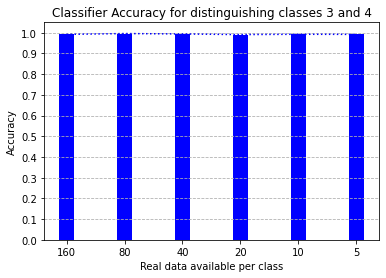

In [ ]:
visualizeComparison([filter1, filter2], test_results_global1)

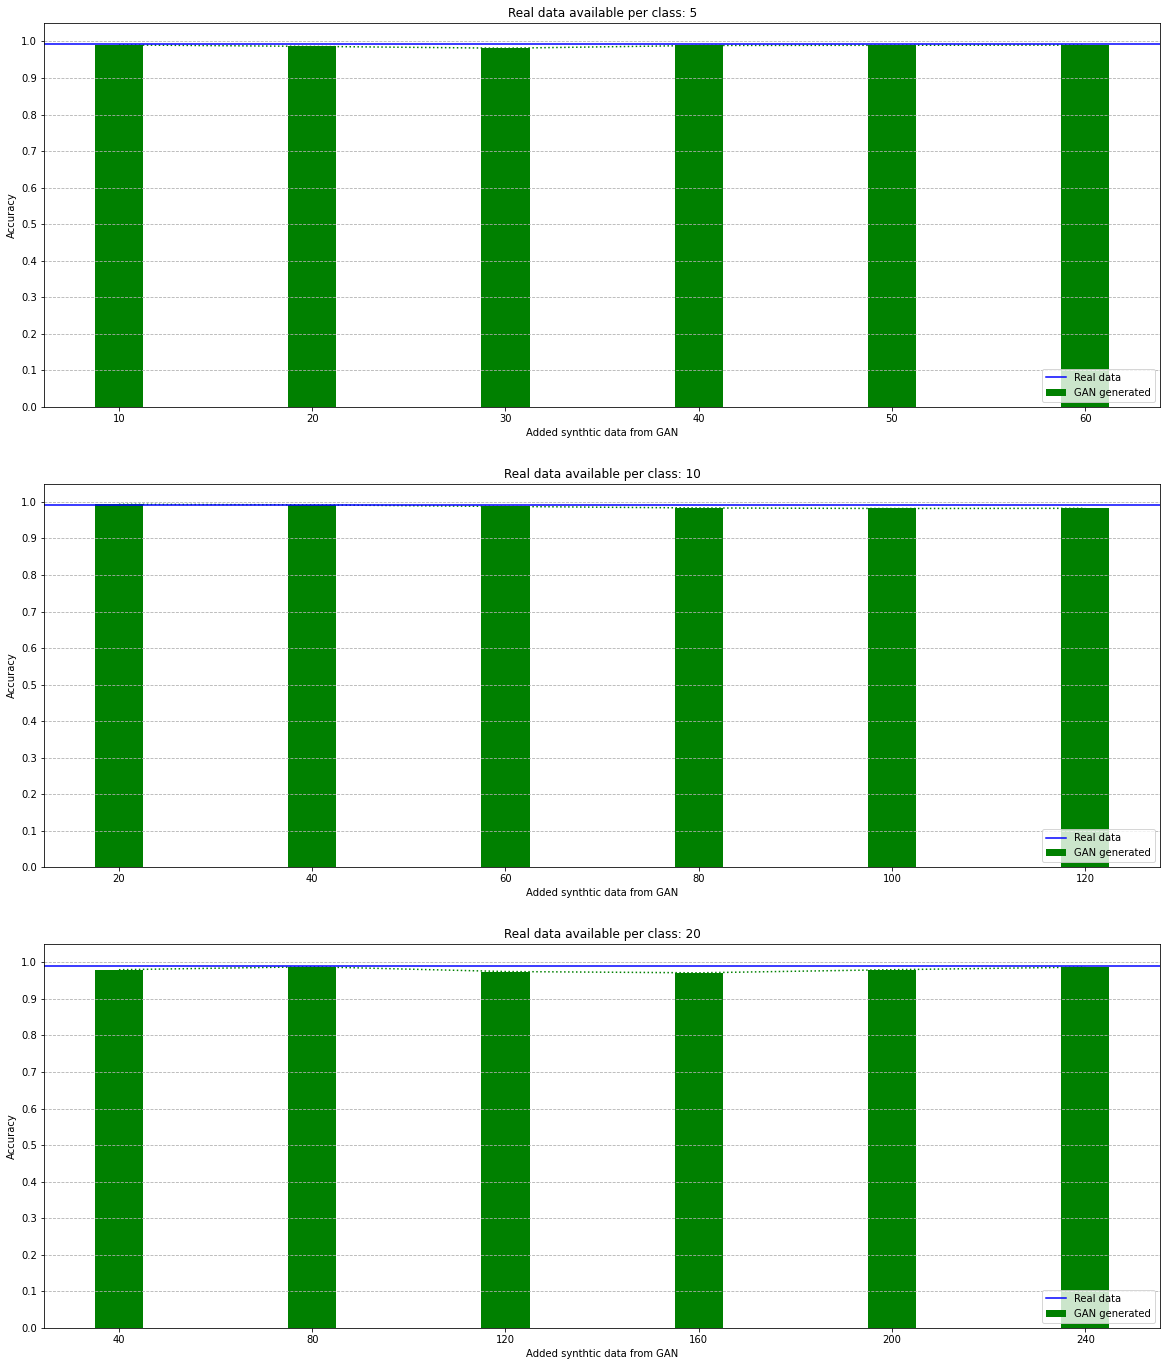

In [ ]:
visualize([filter1, filter2], test_results_global1, test_results_gan_global1)

##**Classes 3 and 8**

###Preparing datasets

In [ ]:
mnist_train, mnist_test = filterAndCastDs(datasets, [filter1, filter3], True)

mnist_list_train, mnistGAN_list_train = prepareDs([filter1, filter3])

###CNNs trained with data

In [ ]:
EPOCH_LIST = [40, 20, 10, 5, 4, 2]

test_results_global2 = trainCNNlist(mnist_list_train, mnist_test, EPOCH_LIST, SEED_LIST)

In [ ]:
EPOCH_LIST = [40, 20, 10]

test_results_gan_global2 = []
test_results_gan_global2.append(trainCNNlist(mnistGAN_list_train[0], mnist_test, EPOCH_LIST[0], SEED_LIST))
test_results_gan_global2.append(trainCNNlist(mnistGAN_list_train[1], mnist_test, EPOCH_LIST[1], SEED_LIST))
test_results_gan_global2.append(trainCNNlist(mnistGAN_list_train[2], mnist_test, EPOCH_LIST[2], SEED_LIST))

###**Visualizations**

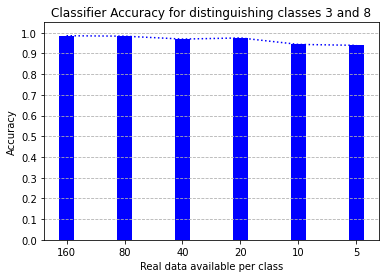

In [ ]:
visualizeComparison([filter1, filter3], test_results_global2)

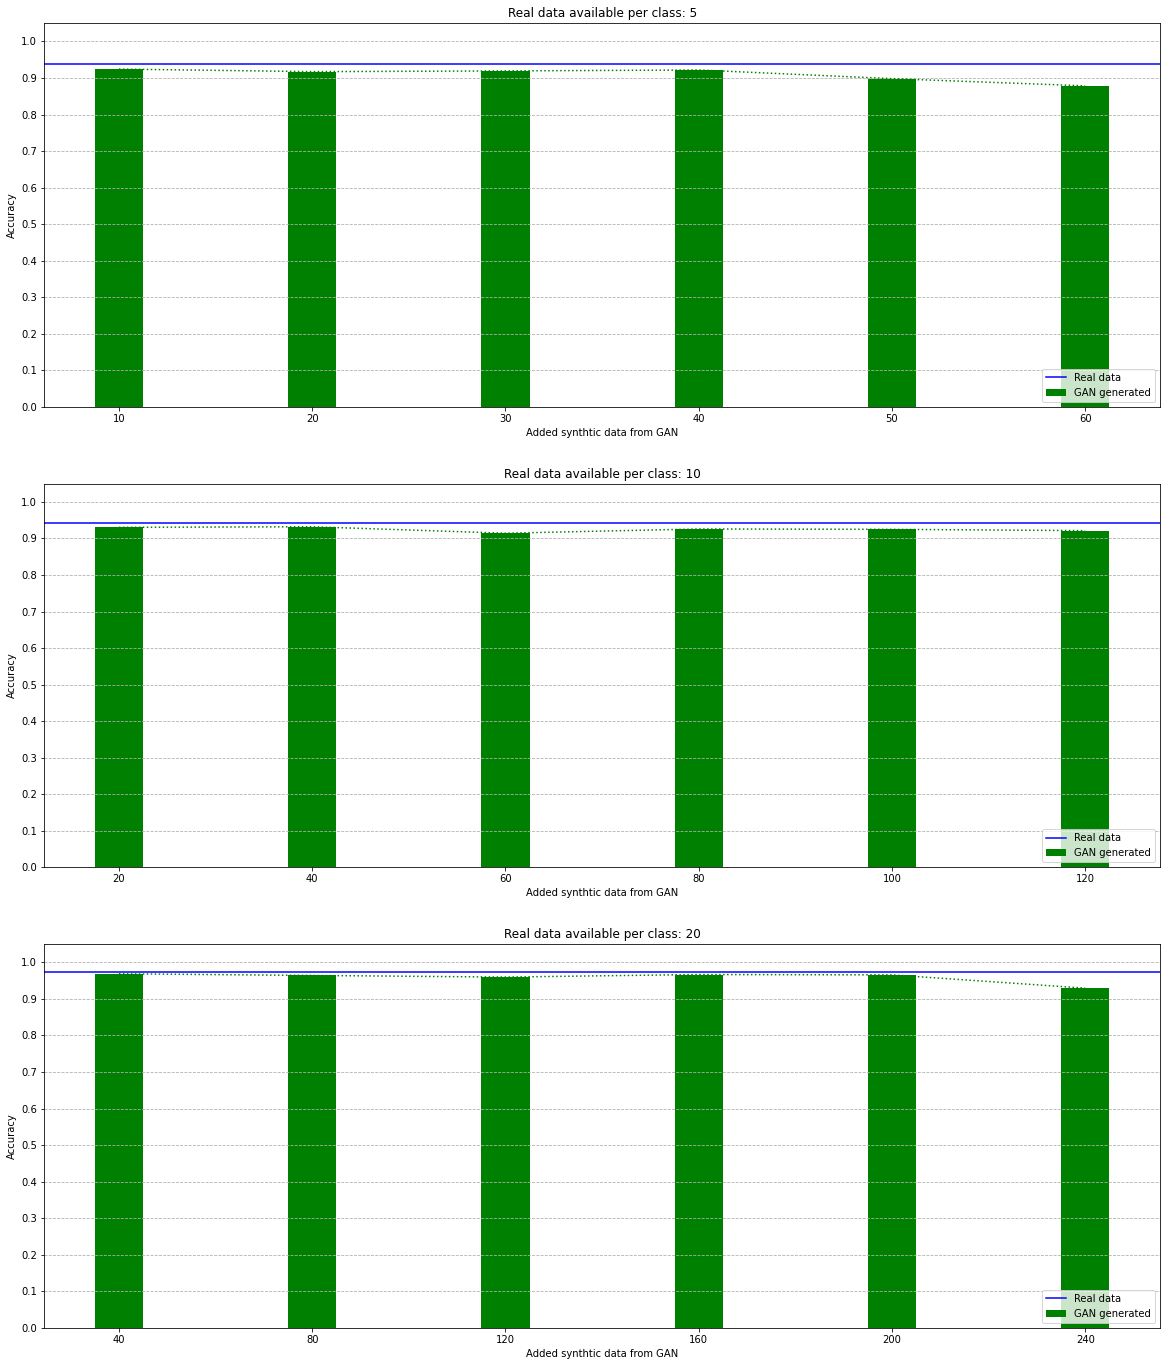

In [ ]:
visualize([filter1, filter3], test_results_global2, test_results_gan_global2)

##**Classes 3, 4 and 8**

###Preparing datasets

In [ ]:
mnist_train, mnist_test = filterAndCastDs(datasets, [filter1, filter2, filter3], True)

mnist_list_train, mnistGAN_list_train = prepareDs([filter1, filter2, filter3])

###CNNs trained with data

In [ ]:
EPOCH_LIST = [40, 20, 10, 5, 3, 2]

test_results_global3 = trainCNNlist(mnist_list_train, mnist_test, EPOCH_LIST, SEED_LIST)

In [ ]:
EPOCH_LIST = [40, 20, 10]

test_results_gan_global3 = []
test_results_gan_global3.append(trainCNNlist(mnistGAN_list_train[0], mnist_test, EPOCH_LIST[0], SEED_LIST))
test_results_gan_global3.append(trainCNNlist(mnistGAN_list_train[1], mnist_test, EPOCH_LIST[1], SEED_LIST))
test_results_gan_global3.append(trainCNNlist(mnistGAN_list_train[2], mnist_test, EPOCH_LIST[2], SEED_LIST))

###**Visualizations**

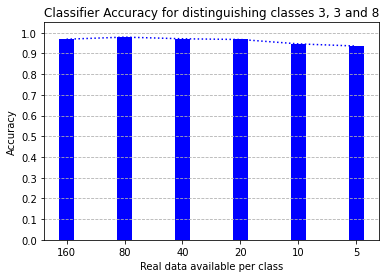

In [ ]:
visualizeComparison([filter1, filter2, filter3], test_results_global3)

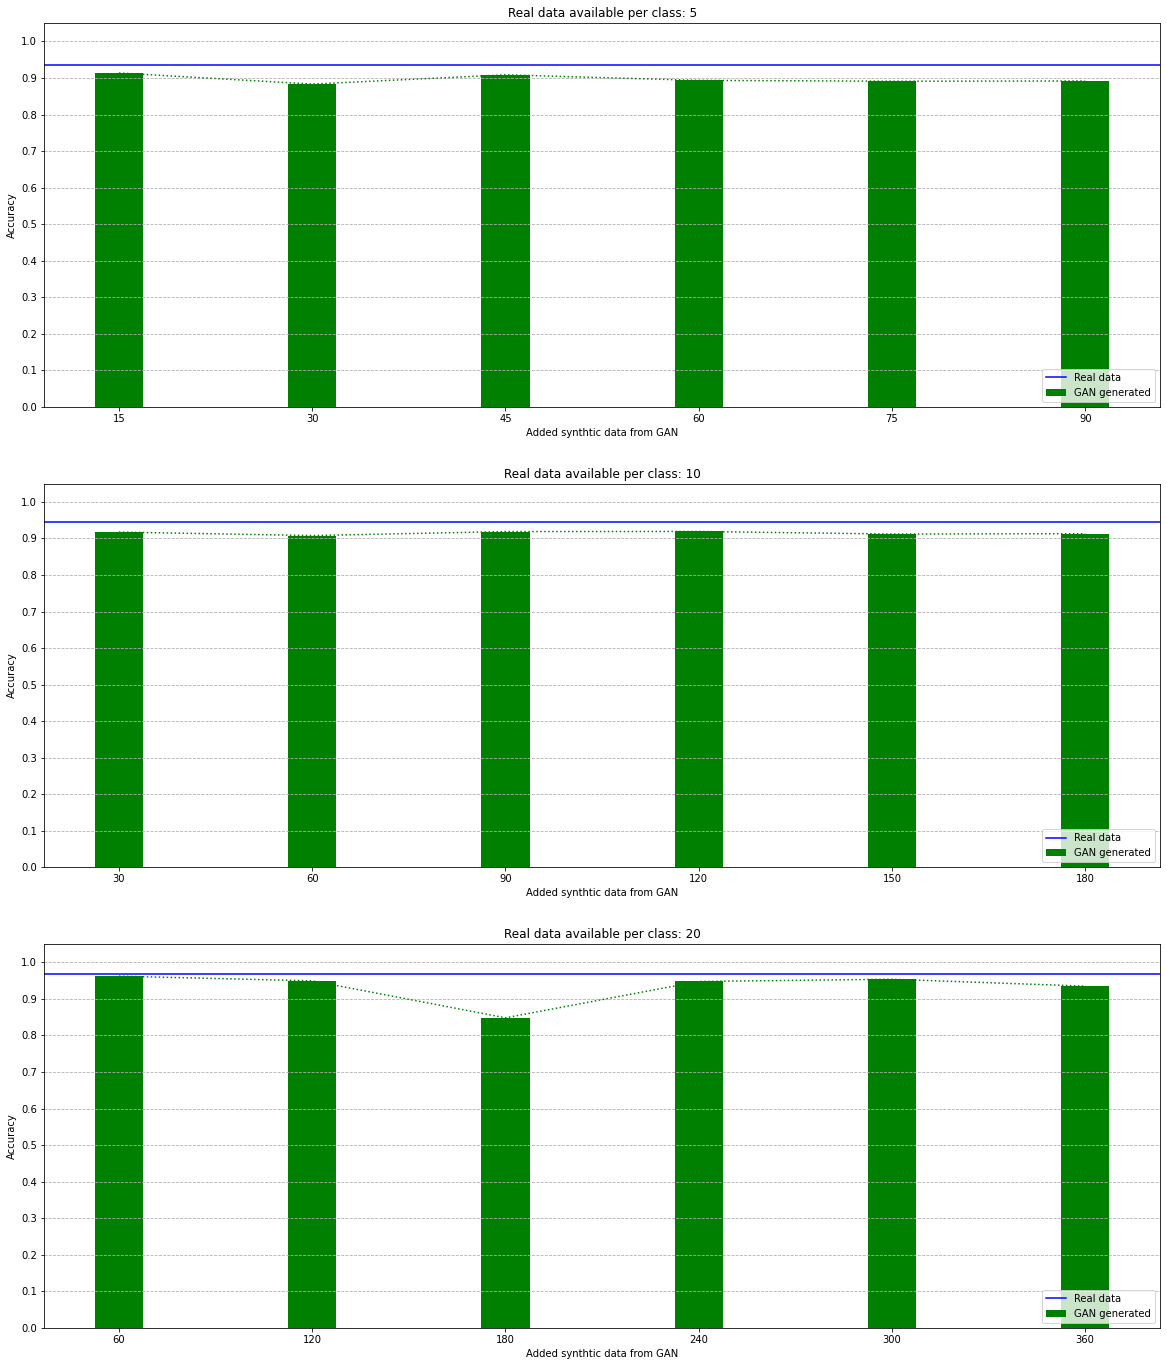

In [ ]:
visualize([filter1, filter2, filter3], test_results_global3, test_results_gan_global3)